In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import glob
import os
batch_size = 8
epochs = 20
test_size = 0.1
n = 60

In [2]:
import os
import numpy as np


path_data = r"C:\Users\bramv\Downloads\capstone-group-6\datasets"

postfix = ["0","_1000to1050","_1050to1400",  "_1400to2000", "_2000to3000", 
           "_3000to4000", "_4000to5000", "_5000to6000", "_6000to7000", "_7000to8000"]

k_all = []
h_all = []

for p in postfix:
    # Construct file names (with .txt)
    k_file = os.path.join(path_data, f"k_set{p}.txt")
    h_file = os.path.join(path_data, f"h_set{p}.txt")
    
    # Load the k file
    if os.path.exists(k_file):
        k_data = np.loadtxt(k_file)
        # Assuming each row is a 3600-long array, otherwise reshape
        if k_data.ndim == 1:  # single array
            k_all.append(k_data)
        else:  # multiple arrays
            k_all.extend(k_data)
    else:
        print(f"Warning: {k_file} not found.")
    
    # Load the h file
    if os.path.exists(h_file):
        h_data = np.loadtxt(h_file)
        if h_data.ndim == 1:
            h_all.append(h_data)
        else:
            h_all.extend(h_data)
    else:
        print(f"Warning: {h_file} not found.")
k_data = np.array(k_all).reshape(-1, 60, 60, 1)
h_data = np.array(h_all).reshape(-1, 60, 60, 1)
print(f"Total k grids loaded: {len(k_data)}")
print(f"Total h grids loaded: {len(h_data)}")


Total k grids loaded: 8000
Total h grids loaded: 8000


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    k_data, h_data, test_size=test_size, random_state=42
)

In [4]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x

    # Encoder
    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    c3 = conv_block(p2, 64)
    c3 = layers.Dropout(0.3)(c3)

    # Decoder
    def up_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = layers.concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    u2 = up_block(c3, c2, 32)
    u1 = up_block(u2, c1, 16)

    outputs = layers.Conv2D(1, 1, activation='linear')(u1)

    model = models.Model(inputs, outputs)
    return model


In [5]:
def laplacian(h):
    return (
        -4.0 * h
        + tf.roll(h, 1, axis=1)
        + tf.roll(h, -1, axis=1)
        + tf.roll(h, 1, axis=2)
        + tf.roll(h, -1, axis=2)
    )

def sink_penalty(h):
    lap = laplacian(h)
    # penalize only negative Laplacian
    return tf.reduce_mean(tf.nn.relu(-lap))

def curvature_penalty(h):
    dx2 = h[:, 2:, 1:-1, :] - 2*h[:, 1:-1, 1:-1, :] + h[:, :-2, 1:-1, :]
    dy2 = h[:, 1:-1, 2:, :] - 2*h[:, 1:-1, 1:-1, :] + h[:, 1:-1, :-2, :]
    return tf.reduce_mean(dx2**2 + dy2**2)

def physics_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    sink = sink_penalty(y_pred)
    curvature = curvature_penalty(y_pred)

    return (
        mse
        + 0.1 * sink        # suppress closed contours
        + 0.01 * curvature # smooth equipotential lines
    )

model = unet_model((n, n, 1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=physics_loss,
    metrics=['mse']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 60, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 60, 60,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 60, 60,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 60, 60,    │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 30, 30,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 15, 15,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 15,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 30, 30,    │      8,224 │ dropout[0][0]   

 Total params: 118,033 (461.07 KB)

 Trainable params: 117,393 (458.57 KB)

 Non-trainable params: 640 (2.50 KB)

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - loss: 19349.6289 - mse: 19349.3633 - val_loss: 15523.5264 - val_mse: 15522.9473 - learning_rate: 0.0010
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 9706.0977 - mse: 9705.4590 - val_loss: 4524.7886 - val_mse: 4524.0703 - learning_rate: 0.0010
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 2175.3899 - mse: 2174.7317 - val_loss: 692.2182 - val_mse: 691.4673 - learning_rate: 0.0010
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 392.4318 - mse: 391.7593 - val_loss: 237.9329 - val_mse: 237.4149 - learning_rate: 0.0010
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 286.3083 - mse: 285.6483 - val_loss: 219.3776 - val_mse: 218.8145 - learning_rate: 0.0010
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 280.4907 - mse: 279.8322 - val_loss: 194.1750 - val_mse: 193.6351 - learning_rate: 0.0010
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 267.7871 - m

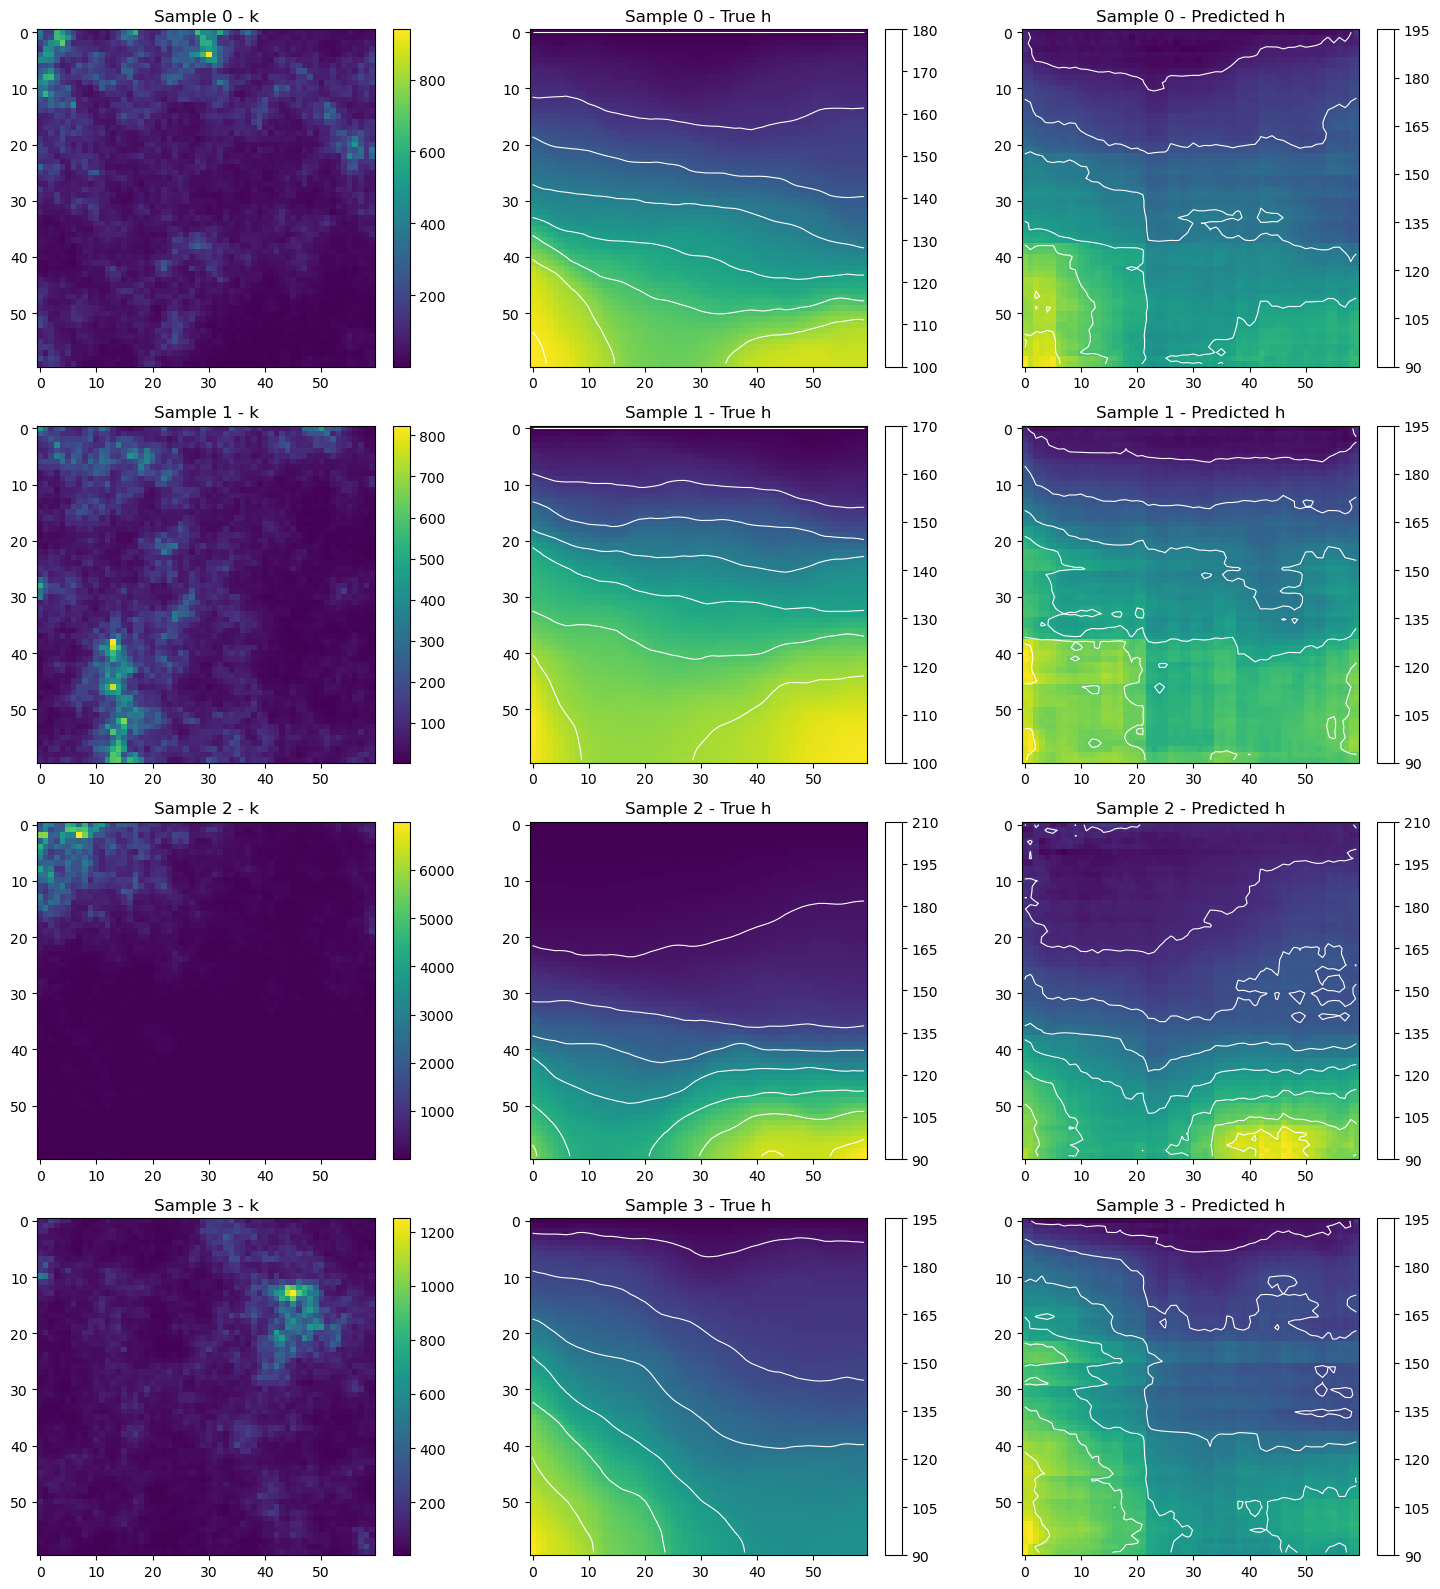

In [11]:


num_samples = 4
plt.figure(figsize=(15, num_samples * 4))

for i in range(num_samples):
    k_sample = X_test[i, :, :, 0]      # 2D grid
    h_true = y_test[i, :, :, 0]        # 2D grid
    h_pred = model.predict(X_test[i:i+1], verbose=0)[0, :, :, 0]  # 2D grid

    # Plot k
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.title(f"Sample {i} - k")
    plt.imshow(k_sample, cmap='viridis')
    plt.colorbar(fraction=0.046, pad=0.04)

    # Plot true h with contour
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.title(f"Sample {i} - True h")
    plt.imshow(h_true, cmap='viridis')
    plt.contour(h_true, colors='white', linewidths=0.8)  # contours
    plt.colorbar(fraction=0.046, pad=0.04)

    # Plot predicted h with contour
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.title(f"Sample {i} - Predicted h")
    plt.imshow(h_pred, cmap='viridis')
    plt.contour(h_pred, colors='white', linewidths=0.8)  # contours
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
